In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## TOC:
#### Big Data
* [Evaluating MongoDb](#mongo)
* [Data Processing](#data-processing)
* [Loading post processed data](#post-process)

#### Advanced Data Analytics
* [Time Series Analysis](#ts)
* [Dealing with missing values](#miss)
* [Prepare time series](#prep)
* [Forecast modeling](#forecast)

In [29]:
df = pd.read_csv("ProjectTweets.csv")

In [30]:
df.head() # let's see what we are dealing with

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [31]:
# Create a new DataFrame with the first row containing the original column names
new_row = pd.DataFrame([df.columns], columns=df.columns)

# Concatenate the new row with the original DataFrame
df = pd.concat([new_row, df], ignore_index=True)
df.drop(columns=['0'], inplace=True)

df.reset_index(drop=True, inplace=True)

In [32]:
df.columns = ["tweet_id", "date", "flag", "user", "text"]
df.head()

,tweet_id,date,flag,user,text
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   tweet_id  1600000 non-null  object
 1   date      1600000 non-null  object
 2   flag      1600000 non-null  object
 3   user      1600000 non-null  object
 4   text      1600000 non-null  object
dtypes: object(5)
memory usage: 61.0+ MB


In [62]:
# remove commas for csv split
df['text'] = df['text'].str.replace(',', '')

In [63]:
# testing
contains_char = df['text'].str.contains(',')
count = contains_char.sum()
print(f"Number of rows: {count}")

Number of rows: 0


In [64]:
# exporting csv to store on HBASE
df.to_csv("tweets.csv", header=False, index=False, sep=',')

### Loading data into MongoDB (NoSql) <a class="anchor" id="mongo"></a>
Not working. Only to demostrate the evaluation process

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import to_timestamp

In [8]:
spark = SparkSession.builder.appName("MongoDB") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12-10.2.0") \
    .config("spark.mongodb.connection.uri", "mongodb://localhost:27017/") \
    .config("spark.mongodb.database", "twitter_db") \
    .config("spark.mongodb.collection", "tweets") \
    .getOrCreate()

23/10/22 12:46:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [9]:
spark.stop() #need to stop and restart to have a fresh new session

In [10]:
spark = SparkSession.builder.appName("MongoDB") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12-10.2.0") \
    .config("spark.mongodb.connection.uri", "mongodb://localhost:27017/") \
    .config("spark.mongodb.database", "twitter_db") \
    .config("spark.mongodb.collection", "tweets") \
    .getOrCreate()

In [11]:
print(spark.sparkContext.getConf().toDebugString())

spark.app.id=local-1697975211175
spark.app.name=MongoDB
spark.app.startTime=1697975210785
spark.app.submitTime=1697975158225
spark.driver.extraJavaOptions=-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.driver.host=10.0.2.15
spark.driver

In [12]:
print(f'The PySpark {spark.version} version is running...')

The PySpark 3.5.0 version is running...


In [13]:
my_schema = StructType([ StructField("n/a", StringType(), True)\
                   ,StructField("tweet_id", StringType(), True)\
                      ,StructField("date", StringType(), True)\
                      ,StructField("flag", StringType(), True)\
                      ,StructField("user", StringType(), True)\
                      ,StructField("text", StringType(), True)])

In [14]:
data = spark.createDataFrame(df, schema=my_schema)

In [13]:
data.show(5)

2023-10-19 15:27:24,448 WARN scheduler.TaskSetManager: Stage 0 contains a task of very large size (194599 KiB). The maximum recommended task size is 1000 KiB.


+---+----------+--------------------+--------+---------------+--------------------+
|n/a|  tweet_id|                date|    flag|           user|                text|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [15]:
data.write.format("mongodb").mode("append").save()

23/10/22 12:47:41 WARN TaskSetManager: Stage 0 contains a task of very large size (194602 KiB). The maximum recommended task size is 1000 KiB.
23/10/22 12:47:48 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker
23/10/22 12:47:48 ERROR Executor: Exception in task 0.0 in stage 0.0 (TID 0)
java.lang.NoSuchMethodError: org.apache.spark.sql.catalyst.encoders.RowEncoder$.apply(Lorg/apache/spark/sql/types/StructType;)Lorg/apache/spark/sql/catalyst/encoders/ExpressionEncoder;
	at com.mongodb.spark.sql.connector.schema.InternalRowToRowFunction.<init>(InternalRowToRowFunction.java:44)
	at com.mongodb.spark.sql.connector.schema.RowToBsonDocumentConverter.<init>(RowToBsonDocumentConverter.java:84)
	at com.mongodb.spark.sql.connector.write.MongoDataWriter.<init>(MongoDataWriter.java:74)
	at com.mongodb.spark.sql.connector.write.MongoDataWriterFactory.createWriter(MongoDataWriterFactory.java:53)
	at org.apache.spark.sql.execution.data

Py4JJavaError: An error occurred while calling o132.save.
: org.apache.spark.SparkException: Writing job failed.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.writingJobFailedError(QueryExecutionErrors.scala:902)
	at org.apache.spark.sql.execution.datasources.v2.V2TableWriteExec.writeWithV2(WriteToDataSourceV2Exec.scala:411)
	at org.apache.spark.sql.execution.datasources.v2.V2TableWriteExec.writeWithV2$(WriteToDataSourceV2Exec.scala:359)
	at org.apache.spark.sql.execution.datasources.v2.AppendDataExec.writeWithV2(WriteToDataSourceV2Exec.scala:225)
	at org.apache.spark.sql.execution.datasources.v2.V2ExistingTableWriteExec.run(WriteToDataSourceV2Exec.scala:337)
	at org.apache.spark.sql.execution.datasources.v2.V2ExistingTableWriteExec.run$(WriteToDataSourceV2Exec.scala:336)
	at org.apache.spark.sql.execution.datasources.v2.AppendDataExec.run(WriteToDataSourceV2Exec.scala:225)
	at org.apache.spark.sql.execution.datasources.v2.V2CommandExec.result$lzycompute(V2CommandExec.scala:43)
	at org.apache.spark.sql.execution.datasources.v2.V2CommandExec.result(V2CommandExec.scala:43)
	at org.apache.spark.sql.execution.datasources.v2.V2CommandExec.executeCollect(V2CommandExec.scala:49)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:312)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:248)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 1 times, most recent failure: Lost task 0.0 in stage 0.0 (TID 0) (10.0.2.15 executor driver): java.lang.NoSuchMethodError: org.apache.spark.sql.catalyst.encoders.RowEncoder$.apply(Lorg/apache/spark/sql/types/StructType;)Lorg/apache/spark/sql/catalyst/encoders/ExpressionEncoder;
	at com.mongodb.spark.sql.connector.schema.InternalRowToRowFunction.<init>(InternalRowToRowFunction.java:44)
	at com.mongodb.spark.sql.connector.schema.RowToBsonDocumentConverter.<init>(RowToBsonDocumentConverter.java:84)
	at com.mongodb.spark.sql.connector.write.MongoDataWriter.<init>(MongoDataWriter.java:74)
	at com.mongodb.spark.sql.connector.write.MongoDataWriterFactory.createWriter(MongoDataWriterFactory.java:53)
	at org.apache.spark.sql.execution.datasources.v2.WritingSparkTask.run(WriteToDataSourceV2Exec.scala:436)
	at org.apache.spark.sql.execution.datasources.v2.WritingSparkTask.run$(WriteToDataSourceV2Exec.scala:425)
	at org.apache.spark.sql.execution.datasources.v2.DataWritingSparkTask$.run(WriteToDataSourceV2Exec.scala:491)
	at org.apache.spark.sql.execution.datasources.v2.V2TableWriteExec.$anonfun$writeWithV2$2(WriteToDataSourceV2Exec.scala:388)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.sql.execution.datasources.v2.V2TableWriteExec.writeWithV2(WriteToDataSourceV2Exec.scala:385)
	... 44 more
	Suppressed: com.mongodb.spark.sql.connector.exceptions.DataException: Write aborted for: abace19c-5cb2-43f0-8f1a-ee66e0a52f9f. 0/1 tasks completed.
		at com.mongodb.spark.sql.connector.write.MongoBatchWrite.abort(MongoBatchWrite.java:91)
		at org.apache.spark.sql.execution.datasources.v2.V2TableWriteExec.writeWithV2(WriteToDataSourceV2Exec.scala:406)
		... 44 more
Caused by: java.lang.NoSuchMethodError: org.apache.spark.sql.catalyst.encoders.RowEncoder$.apply(Lorg/apache/spark/sql/types/StructType;)Lorg/apache/spark/sql/catalyst/encoders/ExpressionEncoder;
	at com.mongodb.spark.sql.connector.schema.InternalRowToRowFunction.<init>(InternalRowToRowFunction.java:44)
	at com.mongodb.spark.sql.connector.schema.RowToBsonDocumentConverter.<init>(RowToBsonDocumentConverter.java:84)
	at com.mongodb.spark.sql.connector.write.MongoDataWriter.<init>(MongoDataWriter.java:74)
	at com.mongodb.spark.sql.connector.write.MongoDataWriterFactory.createWriter(MongoDataWriterFactory.java:53)
	at org.apache.spark.sql.execution.datasources.v2.WritingSparkTask.run(WriteToDataSourceV2Exec.scala:436)
	at org.apache.spark.sql.execution.datasources.v2.WritingSparkTask.run$(WriteToDataSourceV2Exec.scala:425)
	at org.apache.spark.sql.execution.datasources.v2.DataWritingSparkTask$.run(WriteToDataSourceV2Exec.scala:491)
	at org.apache.spark.sql.execution.datasources.v2.V2TableWriteExec.$anonfun$writeWithV2$2(WriteToDataSourceV2Exec.scala:388)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


### Data Processing with MapReduce/Spark <a class="anchor" id="data-processing"></a>
- Load data into Hbase from csv
- Run Map-Reduce jobs on the tweets data to get insights and pre process the data (ex: removing empty fields)
- Write the output file back to Hbase for further work

Please refer to the report and attached python scripts for additional details on those steps.

### Working with Post Processed Data <a class="anchor" id="post-process"></a>
##### Option 1 - Reading data from Hbase

In [8]:
import happybase

In [14]:
# Connect to HBase
connection = happybase.Connection('localhost')
table = connection.table('processed_tweets')

In [15]:
%%time

# Read data from HBase
data = []
for key, value in table.scan():
    row = {'row_key': key.decode()}
    for column, val in value.items():
        column_name = column.decode().split(':')[1]
        row[column_name] = val.decode()
    data.append(row)

CPU times: user 1min 9s, sys: 2.05 s, total: 1min 11s
Wall time: 2min 11s


In [16]:
%%time
df_hb = pd.DataFrame(data)

CPU times: user 4.46 s, sys: 834 ms, total: 5.3 s
Wall time: 13.5 s


In [17]:
df_hb.head(3)

,row_key,date,sentiment_classification,sentiment_score,text,user
0,1,Fri Apr 17 20:30:31 PDT 2009,negative\t,-0.4458,Working songg aunt nan kinda hard crying I write,xoLovebug224
1,10,Fri Apr 17 20:30:47 PDT 2009,negative\t,-0.4767,USEOFFORCEENT sorry loss honey I hope hurt hea...,customcanvasart
2,100,Fri Apr 17 20:32:16 PDT 2009,neutral\t,0.0,IAmCastiel Get rest,taintedmango


##### Option 2 - Reading data from Hadoop using Spark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("Tweets").getOrCreate()

23/10/27 16:56:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
%%time
data_s = spark.read.csv("hdfs:///CA/sentiment/part-00000")

CPU times: user 8.18 ms, sys: 651 µs, total: 8.83 ms
Wall time: 16.5 s


In [5]:
%%time
df_spark = data_s.toPandas()

CPU times: user 14.1 s, sys: 734 ms, total: 14.8 s
Wall time: 44.1 s


In [6]:
df_spark.head(3)

,_c0,_c1,_c2,_c3,_c4,_c5
0,1,Fri Apr 17 20:30:31 PDT 2009,xoLovebug224,Working songg aunt nan kinda hard crying I write,-0.4458,negative\t
1,10,Fri Apr 17 20:30:47 PDT 2009,customcanvasart,USEOFFORCEENT sorry loss honey I hope hurt hea...,-0.4767,negative\t
2,100,Fri Apr 17 20:32:16 PDT 2009,taintedmango,IAmCastiel Get rest,0.0,neutral\t


## Time Series - Data exploration <a class="anchor" id="ts"></a>

In [26]:
#df_hb.to_csv('file.csv', index=False)

Understanding and exploring data:
- Plot
- Seasonal Decomposition (trend, seasonality, residual/noise)
- Stationary or Non-stationary
- Autocorrelation

In [2]:
df_hb = pd.read_csv("file.csv")
df_hb.head()

,row_key,date,sentiment_classification,sentiment_score,text,user
0,1,Fri Apr 17 20:30:31 PDT 2009,negative\t,-0.4458,Working songg aunt nan kinda hard crying I write,xoLovebug224
1,10,Fri Apr 17 20:30:47 PDT 2009,negative\t,-0.4767,USEOFFORCEENT sorry loss honey I hope hurt hea...,customcanvasart
2,100,Fri Apr 17 20:32:16 PDT 2009,neutral\t,0.0000,IAmCastiel Get rest,taintedmango
3,1000,Fri Apr 17 21:17:34 PDT 2009,positive\t,0.1027,race witch mountain hope gewt,lilpoppett
4,10000,Fri Jun 05 10:16:52 PDT 2009,positive\t,0.7650,JoeJGirl2009 good lolz,xJoeJonasGirlx


In [3]:
print('Polarity distribution:\n')
print(df_hb['sentiment_classification'].value_counts())

Polarity distribution:

positive\t    760036
neutral\t     445879
negative\t    394085
Name: sentiment_classification, dtype: int64


In [4]:
df = df_hb.drop(columns=['row_key', 'sentiment_classification', 'text', 'user'])

In [5]:
df['date'] = df['date'].str.replace(' PDT', '')
df['date'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S %Y')

In [6]:
df.set_index('date', inplace=True)

In [7]:
df.sort_index(inplace=True)

In [8]:
df.head()

,sentiment_score
date,
2009-04-06 22:19:45,-0.3818
2009-04-06 22:19:49,-0.7269
2009-04-06 22:19:53,0.4939
2009-04-06 22:19:57,-0.2500
2009-04-06 22:19:57,-0.4939


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

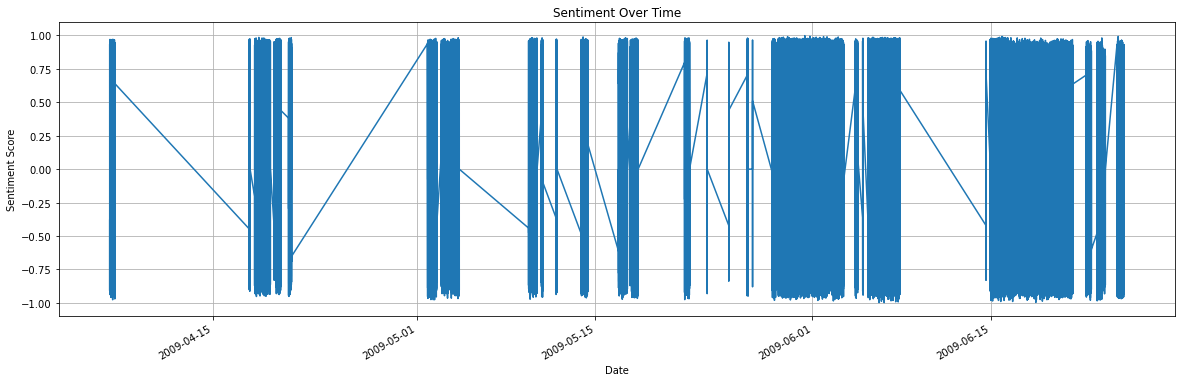

In [15]:
df['sentiment_score'].plot(figsize=(20, 6))
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

In [10]:
df['sentiment_score'].isna().sum()

0

In [10]:
#### DF DAILY

In [10]:
# Resample the data by day and aggregate using mean
df_daily = df['sentiment_score'].resample('D').mean().to_frame()

In [11]:
df_daily.head()

,sentiment_score
date,
2009-04-06,0.150989
2009-04-07,0.168514
2009-04-08,NaN
2009-04-09,NaN
2009-04-10,NaN


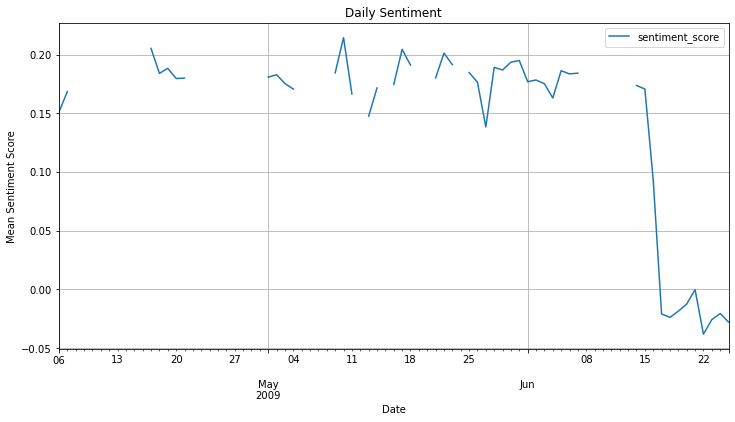

In [11]:
# Plot the daily sentiment data
df_daily.plot(figsize=(12, 6))
plt.title('Daily Sentiment')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment Score')
plt.grid(True)
plt.show()

In [13]:
df_daily['sentiment_score'].isna().sum()

33

In [14]:
df_daily.shape

(81, 1)

In [19]:
print("Missing dates:")
print(df_daily[df_daily['sentiment_score'].isna()].index)

Missing dates:
DatetimeIndex(['2009-04-08', '2009-04-09', '2009-04-10', '2009-04-11',
               '2009-04-12', '2009-04-13', '2009-04-14', '2009-04-15',
               '2009-04-16', '2009-04-22', '2009-04-23', '2009-04-24',
               '2009-04-25', '2009-04-26', '2009-04-27', '2009-04-28',
               '2009-04-29', '2009-04-30', '2009-05-05', '2009-05-06',
               '2009-05-07', '2009-05-08', '2009-05-12', '2009-05-15',
               '2009-05-19', '2009-05-20', '2009-05-24', '2009-06-08',
               '2009-06-09', '2009-06-10', '2009-06-11', '2009-06-12',
               '2009-06-13'],
              dtype='datetime64[ns]', name='date', freq=None)


In [20]:
df_daily.tail()

,sentiment_score
date,
2009-06-21,-0.000099
2009-06-22,-0.038058
2009-06-23,-0.025709
2009-06-24,-0.020431
2009-06-25,-0.027745


In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [13]:
def decompose(df):
    decomposition = seasonal_decompose(df, model='additive', period=7)
    # Multiplicative seasonality is not appropriate for zero and negative values
    # ('multiplicative' will cause ValuError)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(4, 1, 1)
    plt.plot(df, label='Original Time Series')
    plt.legend()
    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()
    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend()
    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residual (Noise)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
def stationarity(df):
    # Perform Augmented Dickey-Fuller test for stationarity
    result = sm.tsa.adfuller(df['sentiment_score'])

    # Print the ADF test results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'  {key}: {value}')

    # Interpret the ADF test results
    if p_value < 0.05:
        print("The time series is likely stationary (reject the null hypothesis)")
    else:
        print("The time series is likely non-stationary (fail to reject the null hypothesis)")

In [15]:
def autocorrelation(df): # needs stationary ts
    #plt.figure(figsize=(6, 2))
    plot_acf(df['sentiment_score'], lags=7);
    plt.title('Autocorrelation Function (ACF) Plot')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.gcf().set_figwidth(6)
    plt.gcf().set_figheight(3)
   # plt.show();

### Dealing with missing values<a class="anchor" id="miss"></a>

#### 1. Impute
#### Mean imputation

In [16]:
df_mean = (df_daily['sentiment_score'].fillna(df_daily['sentiment_score'].mean())).to_frame()

In [36]:
#plt.style.use('seaborn-dark')
plt.style.use('default')

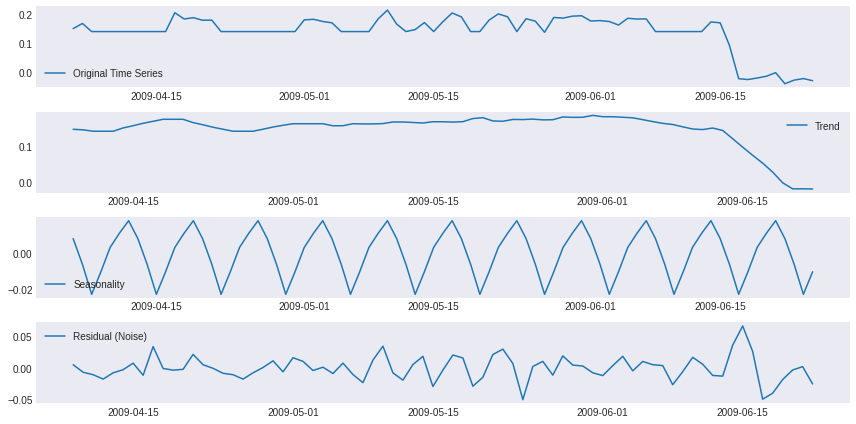

In [25]:
decompose(df_mean)

In [21]:
stationarity(df_mean)

ADF Statistic: -0.469525379335406
p-value: 0.8978274773410009
Critical Values:
  1%: -3.517113604831504
  5%: -2.8993754262546574
  10%: -2.5869547797501644
The time series is likely non-stationary (fail to reject the null hypothesis)


#### Forward Fill

In [17]:
df_ffill = (df_daily['sentiment_score'].fillna(method='ffill')).to_frame()

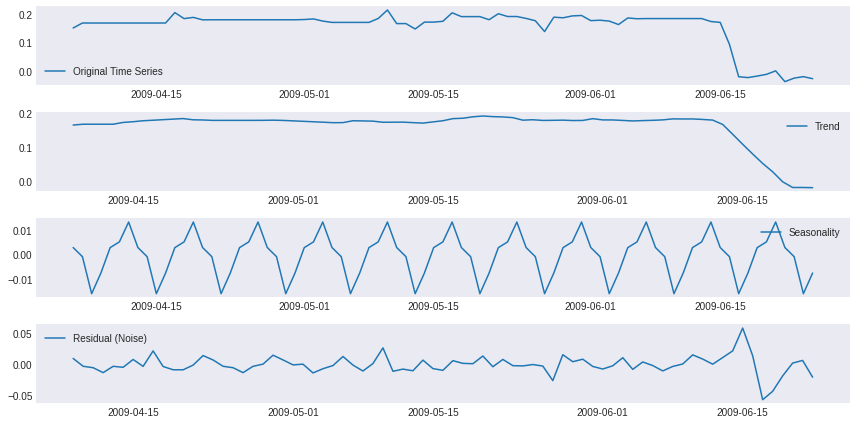

In [26]:
decompose(df_ffill)

In [27]:
stationarity(df_ffill)

ADF Statistic: -0.01207662619701571
p-value: 0.9575218894298305
Critical Values:
  1%: -3.5148692050781247
  5%: -2.8984085156250003
  10%: -2.58643890625
The time series is likely non-stationary (fail to reject the null hypothesis)


#### Backward Fill

In [18]:
df_bfill = (df_daily['sentiment_score'].fillna(method='bfill')).to_frame()

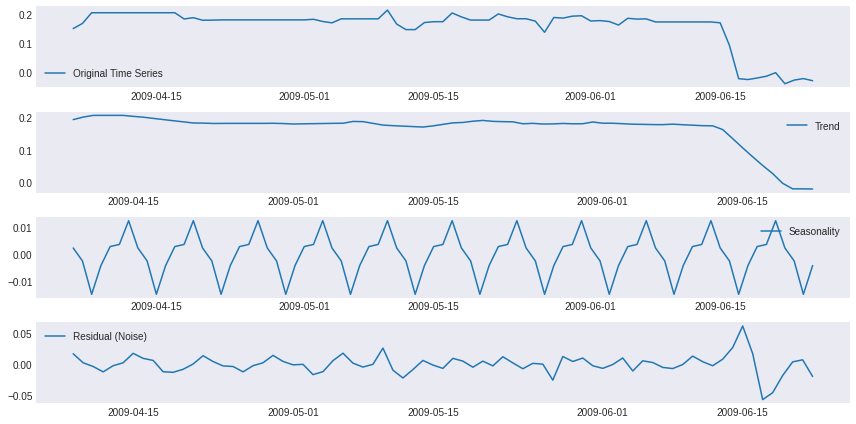

In [29]:
decompose(df_bfill)

In [30]:
stationarity(df_bfill)

ADF Statistic: 0.04262452694047966
p-value: 0.961918324361899
Critical Values:
  1%: -3.5148692050781247
  5%: -2.8984085156250003
  10%: -2.58643890625
The time series is likely non-stationary (fail to reject the null hypothesis)


#### Linear Interpolation

In [19]:
df_int = (df_daily['sentiment_score'].interpolate(method='linear')).to_frame()

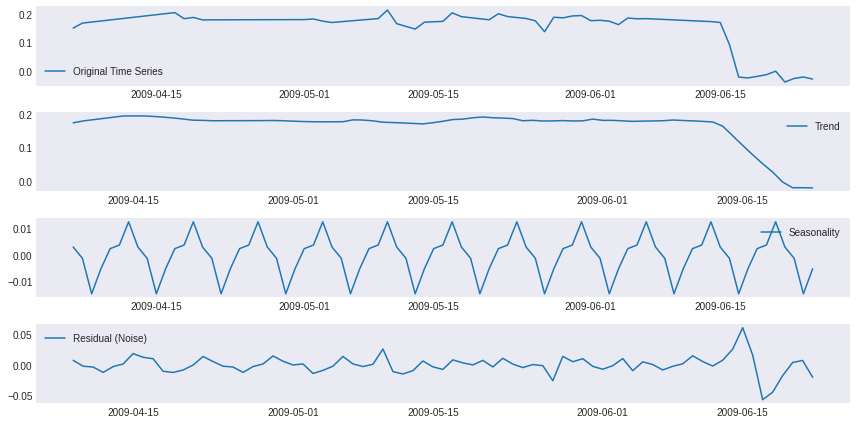

In [32]:
decompose(df_int)

In [33]:
stationarity(df_int)

ADF Statistic: 0.0937476799654404
p-value: 0.9656316175452033
Critical Values:
  1%: -3.5148692050781247
  5%: -2.8984085156250003
  10%: -2.58643890625
The time series is likely non-stationary (fail to reject the null hypothesis)


In [17]:
# adding median and cubic to have the full picture
df_median = (df_daily['sentiment_score'].fillna(df_daily['sentiment_score'].median())).to_frame()
df_cub = (df_daily['sentiment_score'].interpolate(method='cubic')).to_frame()

#### Summary

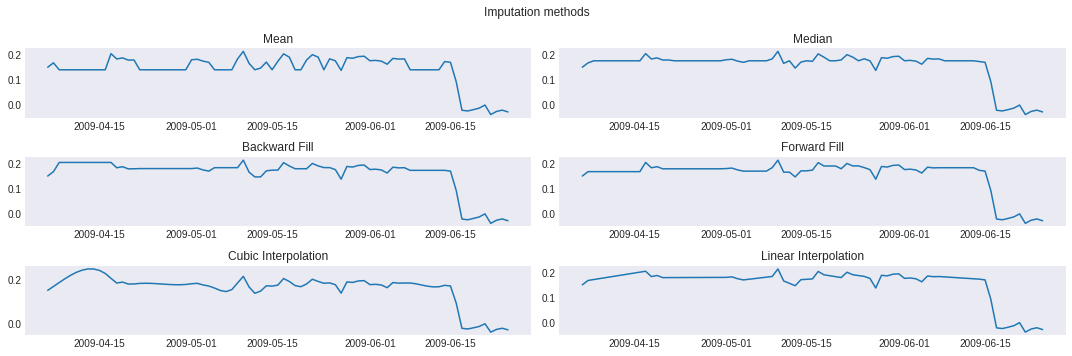

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(15, 5))

axes[0, 0].plot(df_mean)
axes[0, 0].set_title('Mean')
axes[0, 1].plot(df_median)
axes[0, 1].set_title('Median')
axes[1, 1].plot(df_ffill)
axes[1, 1].set_title('Forward Fill')
axes[1, 0].plot(df_bfill)
axes[1, 0].set_title('Backward Fill')
axes[2, 1].plot(df_int)
axes[2, 1].set_title('Linear Interpolation')
axes[2, 0].plot(df_cub)
axes[2, 0].set_title('Cubic Interpolation')

fig.suptitle('Imputation methods')
plt.tight_layout()
plt.show()

In [271]:
# RMSE can't be used due to the lack of original data

#### 2. Delete

In [18]:
df_delete = df_daily.dropna()

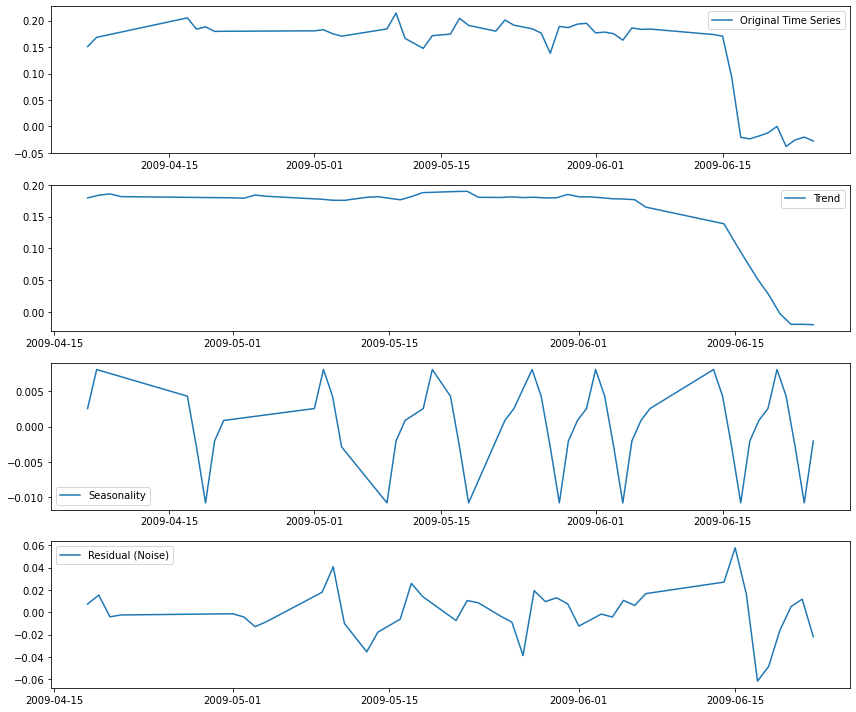

In [62]:
decompose(df_delete)

In [63]:
stationarity(df_delete)

ADF Statistic: -0.17536742051199083
p-value: 0.9413947695992524
Critical Values:
  1%: -3.5778480370438146
  5%: -2.925338105429433
  10%: -2.6007735310095064
The time series is likely non-stationary (fail to reject the null hypothesis)


### Prepare for forecasting<a class="anchor" id="prep"></a>

Candidate dfs are ffill and linear, but we'll make them all non-stationary for final comparison while evaluating model performances

In [20]:
# remove trend
res = seasonal_decompose(df_int['sentiment_score'], model='additive', extrapolate_trend='freq')
detrended = df_int.copy()
detrended['sentiment_score'] = df_int.sentiment_score.values - res.trend

In [22]:
#remove seasonality
res = seasonal_decompose(detrended['sentiment_score'], model='additive', extrapolate_trend='freq')
des_int = detrended.copy()
des_int['sentiment_score'] = detrended.sentiment_score.values - res.seasonal

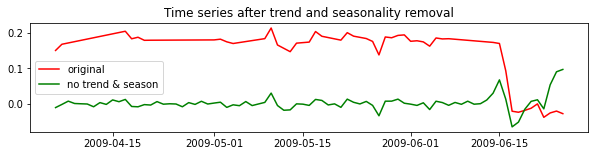

In [30]:
plt.figure(figsize=(10, 2))
plt.plot(df_int, color='r', label='original')
plt.plot(des_int, color='g', label='no trend & season')
plt.title('Time series after trend and seasonality removal')
plt.legend();

In [31]:
stationarity(des_int)

ADF Statistic: -6.231953200524979
p-value: 4.928825367097917e-08
Critical Values:
  1%: -3.5219803175527606
  5%: -2.9014701097664504
  10%: -2.58807215485756
The time series is likely stationary (reject the null hypothesis)


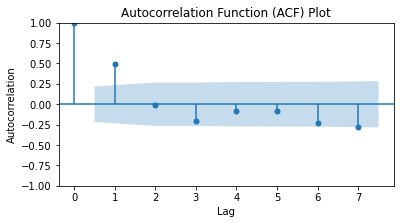

In [32]:
autocorrelation(des_int)

In [33]:
# doing the same for df_ffill
res = seasonal_decompose(df_ffill['sentiment_score'], model='additive', extrapolate_trend='freq')
detrended = df_ffill.copy()
detrended['sentiment_score'] = df_int.sentiment_score.values - res.trend

res = seasonal_decompose(detrended['sentiment_score'], model='additive', extrapolate_trend='freq')
des_ffill = detrended.copy()
des_ffill['sentiment_score'] = detrended.sentiment_score.values - res.seasonal

In [59]:
# let's compare visually the effect of detrending and deseasoning

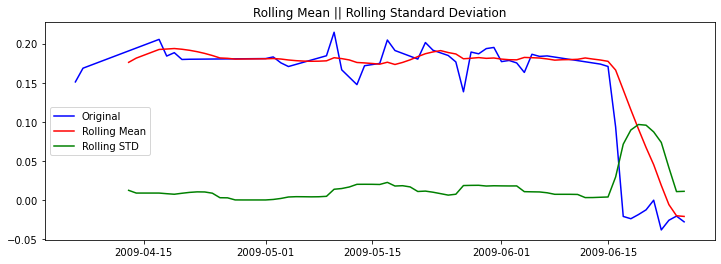

In [34]:
rolling_mean = df_int.rolling(window = 8).mean()
rolling_std = df_int.rolling(window = 8).std()

# ploting the data
plt.plot(df_int, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
plt.legend(loc = 'best')
plt.title('Rolling Mean || Rolling Standard Deviation')
plt.gcf().set_figwidth(12)
plt.gcf().set_figheight(4)
plt.show()

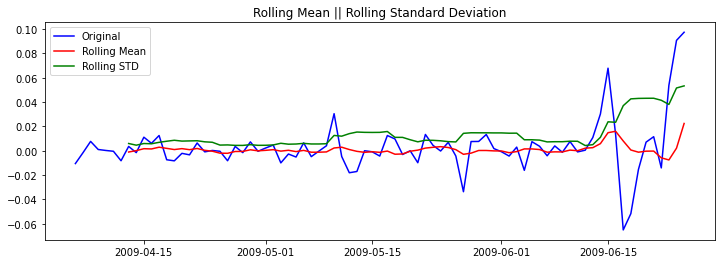

In [24]:
rolling_mean = des_int.rolling(window = 8).mean()
rolling_std = des_int.rolling(window = 8).std()

# ploting the data
plt.plot(des_int, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
plt.legend(loc = 'best')
plt.title('Rolling Mean || Rolling Standard Deviation')
plt.gcf().set_figwidth(12)
plt.gcf().set_figheight(4)
#plt.show()

## Modeling<a class="anchor" id="forecast"></a>

In [35]:
#!pip install scikit-learn
#!pip install xgboost
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [46]:
# Fit, evaluate, and return RMSE for a model and DataFrame
def fit_evaluate_model(model, df):
    
    train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    model = model(train['sentiment_score'])
    model = model.fit()
    
    predictions = model.predict(start=len(train), end=len(train) + len(test) - 1) #, dynamic=False)

    # Calculate RMSE (Root Mean Squared Error) for model evaluation
    rmse_value = np.sqrt(mean_squared_error(test['sentiment_score'], predictions))
    return rmse_value

In [47]:
def compare_models_on_datasets(dfs, models):
    results = []
    for model in models:
        model_name = model.__name__
        print('=======================>', model_name)
        model_results = []
        for df in dfs:
            rmse = fit_evaluate_model(model, df)
            model_results.append(rmse)
        results.append(model_results)
    
    # Create a DataFrame to display the results
    df_results = pd.DataFrame(results, columns=[f'DF{i+1}' for i in range(len(dfs))])
    df_results.index = [model.__name__ for model in models]
    
    return df_results

In [48]:
dfs = [df_median, df_ffill, df_int, des_ffill, des_int]

In [49]:
def sarima_model(x):
    return SARIMAX(x, order=(1, 1, 1))

def arima_model(x):
    return ARIMA(x, order=(0, 1, 1))

def exp_smoothing_model(x):
    return ExponentialSmoothing(x, seasonal='add', seasonal_periods=7)


models = [sarima_model, arima_model, exp_smoothing_model]

In [454]:
comp = compare_models_on_datasets(dfs, models)

=======================> sarima_model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.86440D+00    |proj g|=  3.46542D+00

At iterate    5    f= -2.86496D+00    |proj g|=  2.41644D-01

At iterate   10    f= -2.86581D+00    |proj g|=  4.13822D+00

At iterate   15    f= -2.88047D+00    |proj g|=  5.53299D-01

At iterate   20    f= -2.88958D+00    |proj g|=  1.51308D+01

At iterate   25    f= -2.96176D+00    |proj g|=  1.58639D+00

At iterate   30    f= -2.96328D+00    |proj g|=  7.30805D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final f

In [455]:
comp

,DF1,DF2,DF3,DF4,DF5
sarima_model,0.147114,0.148472,0.148469,0.044844,0.044684
arima_model,0.147061,0.149021,0.149991,0.044988,0.044682
exp_smoothing_model,0.145991,0.146996,0.147818,0.045777,0.045341


In [379]:
# des_int better performing across all models with lower error
# best model is arima (quite close with sarima)

##### Hyperparameters tuning

In [36]:
from sklearn.model_selection import train_test_split

def evaluate_arima(order, data):
    p, d, q = order
    try:
        model = ARIMA(data, order=(p, d, q))
        results = model.fit()
        forecast = results.forecast(steps=len(data))
        rmse = np.sqrt(mean_squared_error(data, forecast))
        return rmse
    except:
        return float('inf')

# Define the hyperparameter search space
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Initialize variables to store best hyperparameters and RMSE
best_rmse = float('inf')
best_order = (0, 0, 0)

In [415]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            rmse = evaluate_arima(order, des_int)
            print(f'P={p} - D={d} - Q={q} : RMSE={rmse}')
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order

P=0 - D=0 - Q=0 : RMSE=0.02176819839790703
P=0 - D=0 - Q=1 : RMSE=0.02244777592028606
P=0 - D=0 - Q=2 : RMSE=0.022720317669612567
P=0 - D=1 - Q=0 : RMSE=0.09679923106762364
P=0 - D=1 - Q=1 : RMSE=0.09697491788194396
P=0 - D=1 - Q=2 : RMSE=0.030005543200697576
P=1 - D=0 - Q=0 : RMSE=0.02408900477931169
P=1 - D=0 - Q=1 : RMSE=0.02322453181123359
P=1 - D=0 - Q=2 : RMSE=0.022805695539761736
P=1 - D=1 - Q=0 : RMSE=0.0969061743523026
P=1 - D=1 - Q=1 : RMSE=0.03148095382045905
P=1 - D=1 - Q=2 : RMSE=0.025232344811334236
P=2 - D=0 - Q=0 : RMSE=0.022730058672186148
P=2 - D=0 - Q=1 : RMSE=0.02314784692839118
P=2 - D=0 - Q=2 : RMSE=0.022430603760365132
P=2 - D=1 - Q=0 : RMSE=0.08760491614664839
P=2 - D=1 - Q=1 : RMSE=0.023629317164512057
P=2 - D=1 - Q=2 : RMSE=0.08114535882676663


In [416]:
print(f"Best ARIMA Order: {best_order}")

Best ARIMA Order: (0, 0, 0)


#### Final model

In [70]:
# Final model
train, test = train_test_split(des_int, train_size=0.8, shuffle=False)
train_data = train['sentiment_score']
test_data = test['sentiment_score']

In [71]:
# Train the ARIMA model with the best hyperparameters
model = ARIMA(train_data, order=(0,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        sentiment_score   No. Observations:                   64
Model:                          ARIMA   Log Likelihood                 210.802
Date:                Wed, 01 Nov 2023   AIC                           -417.605
Time:                        15:15:43   BIC                           -413.287
Sample:                    04-06-2009   HQIC                          -415.904
                         - 06-08-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.821e-05      0.001      0.016      0.987      -0.002       0.002
sigma2      8.056e-05   8.86e-06      9.093      0.000    6.32e-05    9.79e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                30.31
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               2.66   Skew:                            -0.37
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
# Make predictions on the test data
forecast_steps = len(test_data)
forecast = results.get_forecast(steps=forecast_steps)

In [73]:
# Extract the predicted values and confidence intervals
forecast_values = forecast.predicted_mean
y_pred_df = forecast.conf_int(alpha = 0.05)

In [74]:
y_pred_df["Predictions"] = results.predict(start = y_pred_df.index[0], 
                                             end = y_pred_df.index[-1])

In [75]:
# Make predictions for the test data
predicted_values = results.predict(start=len(train), end=len(train) + forecast_steps - 1, typ='levels', dynamic=False)

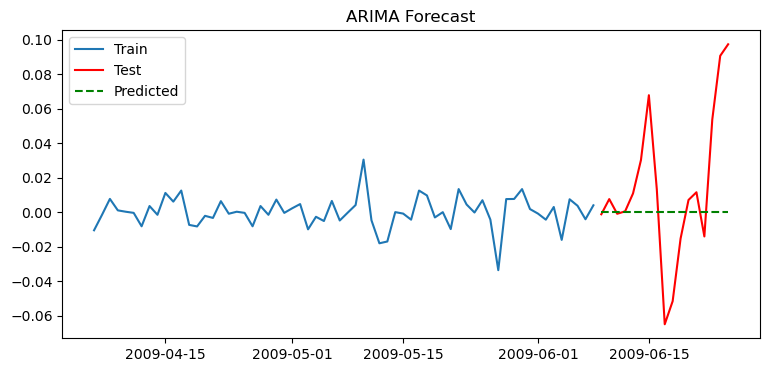

In [93]:
# Plot the original train, test, and predicted data
plt.figure(figsize=(9, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='red')
plt.plot(predicted_values, label='Predicted', linestyle='dashed', color='green')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

In [76]:
np.sqrt(mean_squared_error(test, predicted_values))

0.0446834336366151

##### Rolling Forecast

In [77]:
# Initialize an array to store the rolling forecast values
rolling_forecast = []

# Perform the rolling forecast
for t in range(len(test)):
    # Fit the ARIMA model to the training data up to the current time step
    model = sm.tsa.ARIMA(train[:len(train) + t], order=(0, 0, 0))
    results = model.fit()
    
    # Make a one-step-ahead prediction for the current time step
    forecast = results.forecast(steps=1)
    
    # Append the prediction to the rolling_forecast array
    rolling_forecast.append(forecast[0])

# Convert the rolling_forecast array to a Pandas Series
rolling_forecast = pd.Series(rolling_forecast, index=test.index)

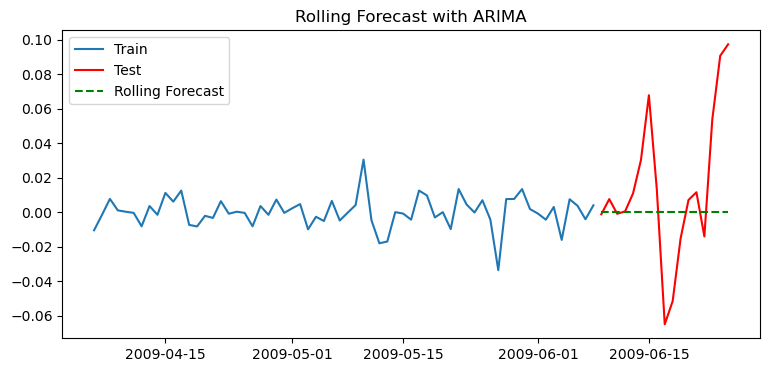

In [95]:
# Plot the original train, test, and rolling forecast data
plt.figure(figsize=(9, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='red')
plt.plot(rolling_forecast, label='Rolling Forecast', linestyle='dashed', color='green')
plt.legend()
plt.title('Rolling Forecast with ARIMA')
plt.show()

In [78]:
np.sqrt(mean_squared_error(test, rolling_forecast))

0.0446834336366151

In [80]:
# let's try recursive autoregression

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [80]:
train, test = train_test_split(des_int, train_size=0.6, shuffle=False)

In [81]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 2
                )

forecaster.fit(y=train['sentiment_score'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2] 
Transformer for y: None 
Transformer for exog: None 
Window size: 2 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-06 00:00:00'), Timestamp('2009-05-23 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-11-01 15:18:20 
Last fit date: 2023-11-01 15:18:20 
Skforecast version: 0.10.1 
Python version: 3.10.12 


In [82]:
# Predictions
# ==============================================================================
steps = 33
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2009-05-24    0.000857
2009-05-25   -0.001637
2009-05-26    0.003922
2009-05-27    0.005656
2009-05-28   -0.000983
Freq: D, Name: pred, dtype: float64

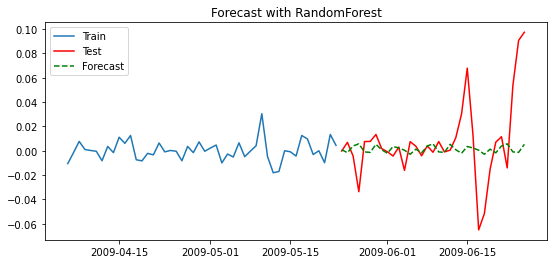

In [41]:
plt.figure(figsize=(9, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='red')
plt.plot(predictions, label='Forecast', linestyle='dashed', color='green')
plt.legend()
plt.title('Forecast with RandomForest')
plt.show()

In [83]:
np.sqrt(mean_squared_error(test, predictions))

0.0327127261584024

In [50]:
#!pip install --upgrade ipywidgets
#from tqdm import tqdm as tqdm

In [42]:
# Hyperparameter Grid search
# ==============================================================================
steps = 33
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [1, 2, 5, 10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [1, 3, 5, 10]}



results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['sentiment_score'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 60.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 3, 'n_estimators': 300}
  Backtesting metric: 9.010919956118014e-05



##### Final model

In [98]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=300, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 5
             )

forecaster.fit(y=train['sentiment_score'])

In [99]:
predictions = forecaster.predict(steps=steps)

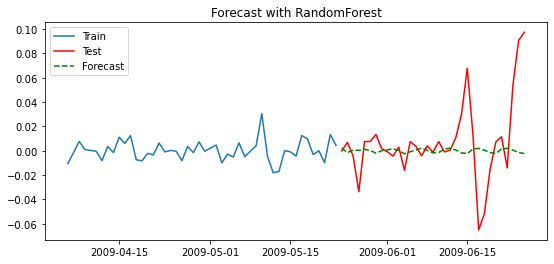

In [46]:
plt.figure(figsize=(9, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='red')
plt.plot(predictions, label='Forecast', linestyle='dashed', color='green')
plt.legend()
plt.title('Forecast with RandomForest')
plt.show()

In [100]:
np.sqrt(mean_squared_error(test, predictions))

0.03362833415550229

#### LGBM

In [108]:
from lightgbm import LGBMRegressor

In [121]:
np.sqrt(mean_squared_error(test, y_pred))

0.03295457905370939

In [126]:
model = LGBMRegressor(n_estimators=100, max_depth=3, random_state=123)

# Extract features and target variable
X_train, y_train = train.index.values, train['sentiment_score']
X_test, y_test = test.index.values, test['sentiment_score']

# Train the LGBMRegressor model
model.fit(X_train.reshape(-1, 1), y_train)

# Make predictions for the test set
y_pred = model.predict(X_test.reshape(-1, 1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1
[LightGBM] [Info] Start training from score 0.000213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [12]:
import gc
gc.collect()

26

In [13]:
spark.catalog.clearCache()